In [ ]:
# -*- coding: utf-8 -*-
# =============================================================================
# PHẦN 1: KHUNG CHƯƠNG TRÌNH - CÁC HÀM TÁI SỬ DỤNG
# Chạy cell này một lần để định nghĩa tất cả các hàm cần thiết.
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# -----------------------------------------------------------------------------
# 1.1. CÁC THUẬT TOÁN
# -----------------------------------------------------------------------------

def algorithm_1_basic_projection(F, P_K, x0, tau, max_iter=2000, tol=1e-7):
    """Thực hiện Thuật toán 1: Chiếu cơ bản."""
    x = np.copy(x0)
    errors = []
    start_time = time.time()
    iterations = 0
    history = [x]

    for k in range(max_iter):
        iterations += 1
        x_next = P_K(x - tau * F(x))
        error = np.linalg.norm(x_next - x)
        errors.append(error)
        history.append(x_next)
        if error < tol:
            break
        x = x_next

    final_error = np.linalg.norm(P_K(x - F(x)) - x)
    end_time = time.time()
    return {
        "converged": error < tol,
        "solution": x, "history": np.array(history), "errors": errors,
        "time": end_time - start_time, "iterations": iterations, "final_error": final_error
    }

def algorithm_2_variable_step(F, P_K, x0, tau, max_iter=2000, tol=1e-7):
    """Thực hiện Thuật toán 2: Chiếu với cỡ bước thay đổi (dùng tau cố định thỏa mãn)."""
    # Logic tương tự Thuật toán 1, chỉ khác ở điều kiện hội tụ của tau
    return algorithm_1_basic_projection(F, P_K, x0, tau, max_iter, tol)

# -----------------------------------------------------------------------------
# 1.2. CÁC HÀM TRỰC QUAN HÓA VÀ HIỂN THỊ
# -----------------------------------------------------------------------------

def plot_results(results, problem_name):
    """Hàm tổng hợp để vẽ tất cả các biểu đồ cần thiết."""
    res1 = results.get("alg1")
    res2 = results.get("alg2")
    n = res1['history'][0].shape[0] if res1 else res2['history'][0].shape[0]

    # Chỉ vẽ biểu đồ đường đi nếu n=2
    if n == 2:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        ax.set_title(f"Đường đi của các điểm lặp cho: {problem_name}", fontsize=16)

        low, up = results['K_bounds']
        ax.fill_between([low[0], up[0]], low[1], up[1], color='lightgray', alpha=0.5, label=f'Tập lồi K')

        if res1 and len(res1['history']) > 1:
            h1 = res1['history']
            ax.plot(h1[:, 0], h1[:, 1], 'o-', color='royalblue', label='Thuật toán 1', markersize=4, alpha=0.8)
            ax.plot(h1[-1, 0], h1[-1, 1], 'X', color='red', markersize=12, markeredgecolor='black', label='Nghiệm T.toán 1')

        if res2 and len(res2['history']) > 1:
            h2 = res2['history']
            ax.plot(h2[:, 0], h2[:, 1], 'o--', color='darkorange', label='Thuật toán 2', markersize=4, alpha=0.8)
            ax.plot(h2[-1, 0], h2[-1, 1], 'P', color='green', markersize=12, markeredgecolor='black', label='Nghiệm T.toán 2')

        start_point = res1['history'][0] if res1 else res2['history'][0]
        ax.plot(start_point[0], start_point[1], 's', color='black', markersize=8, label='Điểm bắt đầu')

        ax.set_xlabel("$x_1$", fontsize=12)
        ax.set_ylabel("$x_2$", fontsize=12)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.axis('equal')
        plt.show()

    # Biểu đồ tốc độ hội tụ
    plt.figure(figsize=(10, 6))
    plt.title(f"Tốc độ hội tụ cho: {problem_name}", fontsize=16)
    if res1 and res1['errors']:
        plt.plot(np.log10(res1['errors']), label='Thuật toán 1', color='royalblue', marker='.', linestyle='-')
    if res2 and res2['errors']:
        plt.plot(np.log10(res2['errors']), label='Thuật toán 2', color='darkorange', marker='.', linestyle='--')
    plt.xlabel("Số vòng lặp (k)", fontsize=12)
    plt.ylabel("$log_{10}(||x^{k+1} - x^k||)$", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# -----------------------------------------------------------------------------
# 1.3. HÀM XỬ LÝ CHÍNH (THE RUNNER)
# -----------------------------------------------------------------------------

def run_and_compare_algorithms(problem):
    """
    Hàm chính để chạy và so sánh các thuật toán cho một bài toán cụ thể.
    """
    pd.set_option('display.width', 120)

    # Lấy thông tin từ problem dictionary
    name = problem["name"]
    n = problem["n"]
    F = problem["F"]
    P_K = problem["P_K"]
    x0 = problem["x0"]
    M = problem.get("M") # Lấy ma trận M nếu có

    print("="*80)
    print(f"BẮT ĐẦU XỬ LÝ: {name} (n={n})")
    print("="*80)

    # Phân tích bài toán nếu là dạng F(x) = Mx + q
    tau_alg1, tau_alg2 = None, None
    alg1_applicable, alg2_applicable = False, False
    results = {"K_bounds": problem["K_bounds"]}

    if M is not None:
        print("\n--- Phân tích bài toán ---")
        eigenvalues = np.linalg.eigvalsh(M)
        alpha = np.min(eigenvalues)
        L = np.max(eigenvalues)
        c = alpha / (L**2) if L > 0 and alpha > 0 else (1/L if L > 0 else 0)

        print(f"  Hằng số đơn điệu mạnh (α): {alpha:.4f}")
        print(f"  Hằng số Lipschitz (L): {L:.4f}")
        print(f"  Hằng số đồng bức (c): {c:.4f}\n")

        # Kiểm tra điều kiện cho Thuật toán 1
        print(">>> Phân tích cho Thuật toán 1 (Chiếu cơ bản):")
        if alpha > 0:
            cond_alg1_upper = 2 * alpha / (L**2)
            tau_alg1 = cond_alg1_upper * 0.98
            alg1_applicable = True
            print(f"  Điều kiện (α > 0): Thỏa mãn. F là đơn điệu mạnh.")
            print(f"  Điều kiện hội tụ: 0 < τ < 2α/L² = {cond_alg1_upper:.4f}")
            print(f"  => Chọn τ = {tau_alg1:.4f}\n")
        else:
            print(f"  Điều kiện (α > 0): KHÔNG thỏa mãn (α = {alpha:.4f}). F không đơn điệu mạnh.")
            print(f"  => Thuật toán 1 không được đảm bảo hội tụ.\n")

        # Kiểm tra điều kiện cho Thuật toán 2
        print(">>> Phân tích cho Thuật toán 2 (Chiếu với cỡ bước thay đổi):")
        if c > 0:
            cond_alg2_upper = 2 * c
            tau_alg2 = cond_alg2_upper * 0.98
            alg2_applicable = True
            print(f"  Điều kiện (c > 0): Thỏa mãn. F là {c:.4f}-đồng bức.")
            print(f"  Điều kiện hội tụ: 0 < τ < 2c = {cond_alg2_upper:.4f}")
            print(f"  => Chọn τ = {tau_alg2:.4f}\n")
        else:
            print(f"  Điều kiện (c > 0): KHÔNG thỏa mãn (c = {c:.4f}).")
            print(f"  => Thuật toán 2 không được đảm bảo hội tụ.\n")
    else:
        print("Bài toán không ở dạng F(x)=Mx+q. Cần cung cấp τ thủ công.")
        # Bạn có thể thêm logic để nhập tau thủ công ở đây nếu muốn
        return

    # Chạy các thuật toán
    print("--- Bắt đầu chạy thuật toán ---\n")
    if alg1_applicable:
        results["alg1"] = algorithm_1_basic_projection(F, P_K, x0, tau_alg1)

    if alg2_applicable:
        results["alg2"] = algorithm_2_variable_step(F, P_K, x0, tau_alg2)

    # Hiển thị bảng kết quả
    table_data = []
    if "alg1" in results:
        res = results["alg1"]
        table_data.append([
            f"{name} (n={n})", "Alg. 1", res["iterations"], f"{res['time']:.5f}",
            f"{res['final_error']:.2e}", f"{tau_alg1:.4f}", "Có" if res["converged"] else "Không"
        ])
    if "alg2" in results:
        res = results["alg2"]
        table_data.append([
            f"{name} (n={n})", "Alg. 2", res["iterations"], f"{res['time']:.5f}",
            f"{res['final_error']:.2e}", f"{tau_alg2:.4f}", "Có" if res["converged"] else "Không"
        ])

    df = pd.DataFrame(table_data, columns=[
        "Problem", "Algorithm", "Iterations", "CPU Time (s)",
        "Final Error", "Step Size (τ)", "Converged"
    ])

    print("\n" + "="*100)
    print("BẢNG KẾT QUẢ THỰC NGHIỆM")
    print("="*100)
    print(df.to_string(index=False))
    print("\n" + "="*100 + "\n")

    # Vẽ biểu đồ
    plot_results(results, name)

In [ ]:
# =============================================================================
# PHẦN 2: ĐỊNH NGHĨA CÁC BÀI TOÁN
# Mỗi hàm dưới đây sẽ tạo và trả về một dictionary chứa đầy đủ thông tin
# của một bài toán cụ thể.
# =============================================================================

def create_problem_strongly_monotone(n=2):
    """Ví dụ 1: F là đơn điệu mạnh và Lipschitz."""
    M = np.array([[4.0, 1.0], [1.0, 3.0]]) if n==2 else np.diag(np.full(n, 4)) + np.diag(np.full(n-1, 1), 1) + np.diag(np.full(n-1, 1), -1)
    q = -np.random.rand(n) * 5 - 1

    low_bounds = np.zeros(n)
    up_bounds = np.ones(n) * 5
    x0 = np.ones(n) * 4.5

    def F(x): return M @ x + q
    def P_K(x): return np.clip(x, low_bounds, up_bounds)

    return {
        "name": "Ví dụ 1 (F đơn điệu mạnh)",
        "n": n,
        "F": F,
        "P_K": P_K,
        "x0": x0,
        "M": M,
        "K_bounds": (low_bounds, up_bounds)
    }

def create_problem_cocoercive(n=2):
    """Ví dụ 2: F là đồng bức nhưng không đơn điệu mạnh."""
    M = np.ones((n, n))
    q = np.array([2.0, -3.0]) if n==2 else np.random.rand(n) * 2 - 1

    low_bounds = np.ones(n) * -5
    up_bounds = np.ones(n) * 5
    x0 = np.array([4.0, -4.0]) if n==2 else np.ones(n)

    def F(x): return M @ x + q
    def P_K(x): return np.clip(x, low_bounds, up_bounds)

    return {
        "name": "Ví dụ 2 (F không đơn điệu mạnh)",
        "n": n,
        "F": F,
        "P_K": P_K,
        "x0": x0,
        "M": M,
        "K_bounds": (low_bounds, up_bounds)
    }

def create_sun_problem_instance(n=10):
    """Ví dụ 3: Bài toán của Sun [18]."""
    M = np.diag(np.full(n, 4)) + np.diag(np.full(n-1, -1), 1) + np.diag(np.full(n-1, -1), -1)
    q = -np.ones(n)

    low_bounds = np.zeros(n)
    up_bounds = np.ones(n)
    x0 = np.zeros(n)

    def F(x): return M @ x + q
    def P_K(x): return np.clip(x, low_bounds, up_bounds)

    return {
        "name": "Ví dụ 5.2 - Sun [18]",
        "n": n,
        "F": F,
        "P_K": P_K,
        "x0": x0,
        "M": M,
        "K_bounds": (low_bounds, up_bounds)
    }

Thực thi

BẮT ĐẦU XỬ LÝ: Ví dụ 1 (F đơn điệu mạnh) (n=2)

--- Phân tích bài toán ---
  Hằng số đơn điệu mạnh (α): 2.3820
  Hằng số Lipschitz (L): 4.6180
  Hằng số đồng bức (c): 0.1117

>>> Phân tích cho Thuật toán 1 (Chiếu cơ bản):
  Điều kiện (α > 0): Thỏa mãn. F là đơn điệu mạnh.
  Điều kiện hội tụ: 0 < τ < 2α/L² = 0.2234
  => Chọn τ = 0.2189

>>> Phân tích cho Thuật toán 2 (Chiếu với cỡ bước thay đổi):
  Điều kiện (c > 0): Thỏa mãn. F là 0.1117-đồng bức.
  Điều kiện hội tụ: 0 < τ < 2c = 0.2234
  => Chọn τ = 0.2189

--- Bắt đầu chạy thuật toán ---


BẢNG KẾT QUẢ THỰC NGHIỆM
                        Problem Algorithm  Iterations CPU Time (s) Final Error Step Size (τ) Converged
Ví dụ 1 (F đơn điệu mạnh) (n=2)    Alg. 1          23      0.00062    2.55e-07        0.2189        Có
Ví dụ 1 (F đơn điệu mạnh) (n=2)    Alg. 2          23      0.00073    2.55e-07        0.2189        Có




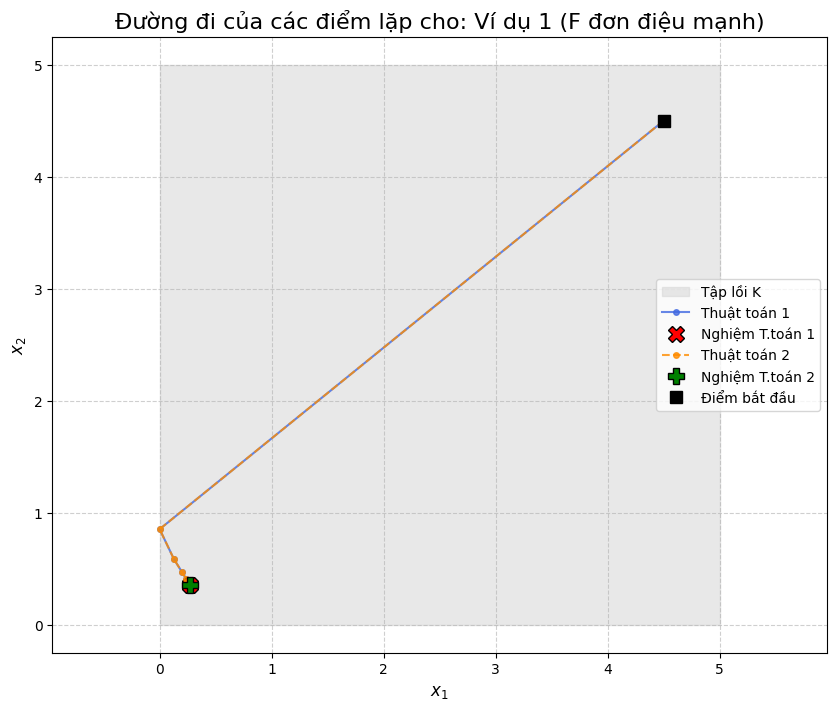

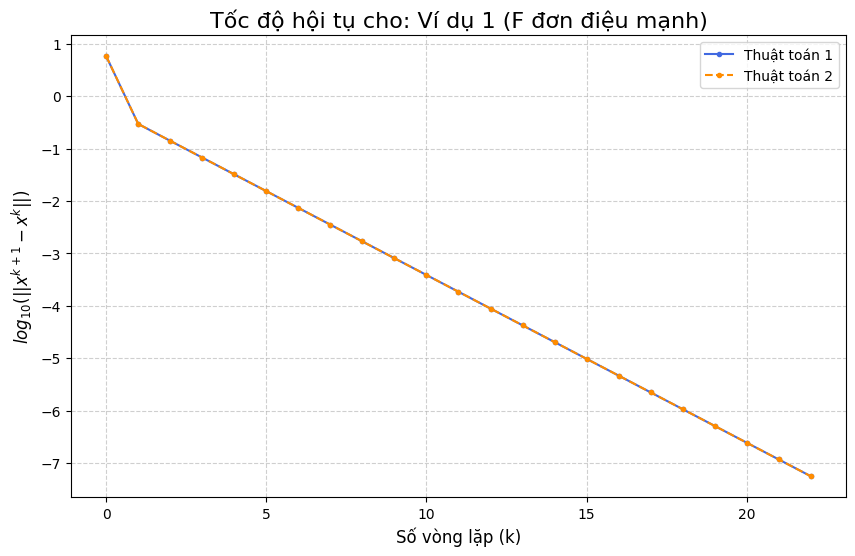

In [ ]:
problem1 = create_problem_strongly_monotone(n=2)
run_and_compare_algorithms(problem1)

BẮT ĐẦU XỬ LÝ: Ví dụ 2 (F không đơn điệu mạnh) (n=2)

--- Phân tích bài toán ---
  Hằng số đơn điệu mạnh (α): 0.0000
  Hằng số Lipschitz (L): 2.0000
  Hằng số đồng bức (c): 0.5000

>>> Phân tích cho Thuật toán 1 (Chiếu cơ bản):
  Điều kiện (α > 0): KHÔNG thỏa mãn (α = 0.0000). F không đơn điệu mạnh.
  => Thuật toán 1 không được đảm bảo hội tụ.

>>> Phân tích cho Thuật toán 2 (Chiếu với cỡ bước thay đổi):
  Điều kiện (c > 0): Thỏa mãn. F là 0.5000-đồng bức.
  Điều kiện hội tụ: 0 < τ < 2c = 1.0000
  => Chọn τ = 0.9800

--- Bắt đầu chạy thuật toán ---


BẢNG KẾT QUẢ THỰC NGHIỆM
                              Problem Algorithm  Iterations CPU Time (s) Final Error Step Size (τ) Converged
Ví dụ 2 (F không đơn điệu mạnh) (n=2)    Alg. 2           5      0.00020    0.00e+00        0.9800        Có




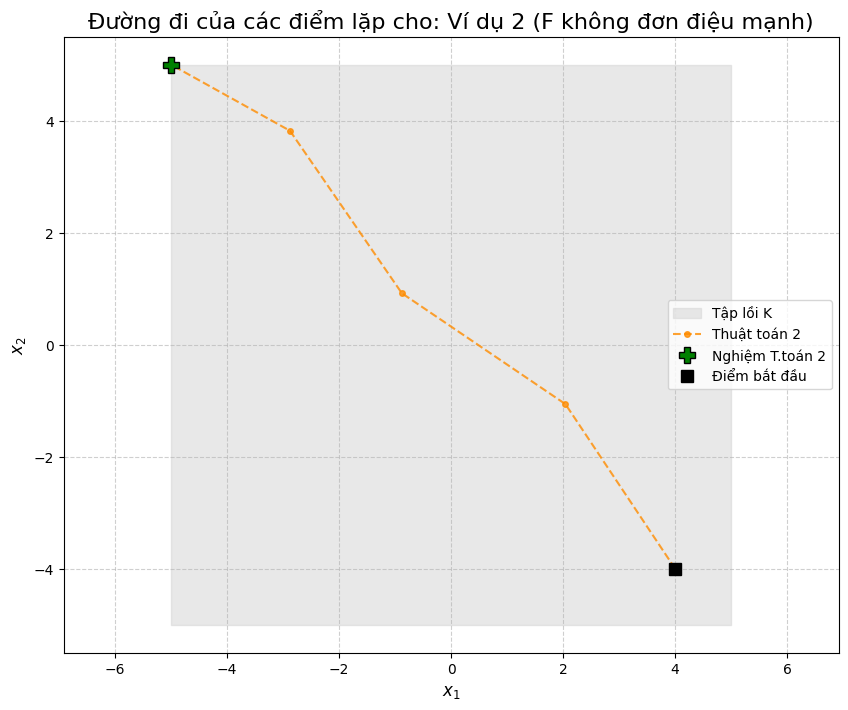

/tmp/ipython-input-2169264545.py:92: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(res2['errors']), label='Thuật toán 2', color='darkorange', marker='.', linestyle='--')


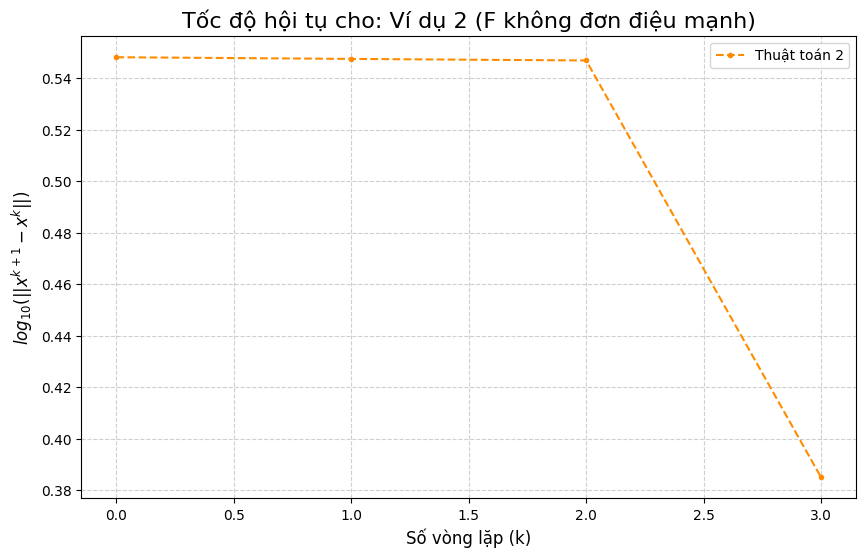

In [ ]:
problem2 = create_problem_cocoercive(n=2)
run_and_compare_algorithms(problem2)

VD của sun

BẮT ĐẦU XỬ LÝ: Ví dụ 5.2 - Sun [18] (n=10)

--- Phân tích bài toán ---
  Hằng số đơn điệu mạnh (α): 2.0810
  Hằng số Lipschitz (L): 5.9190
  Hằng số đồng bức (c): 0.0594

>>> Phân tích cho Thuật toán 1 (Chiếu cơ bản):
  Điều kiện (α > 0): Thỏa mãn. F là đơn điệu mạnh.
  Điều kiện hội tụ: 0 < τ < 2α/L² = 0.1188
  => Chọn τ = 0.1164

>>> Phân tích cho Thuật toán 2 (Chiếu với cỡ bước thay đổi):
  Điều kiện (c > 0): Thỏa mãn. F là 0.0594-đồng bức.
  Điều kiện hội tụ: 0 < τ < 2c = 0.1188
  => Chọn τ = 0.1164

--- Bắt đầu chạy thuật toán ---


BẢNG KẾT QUẢ THỰC NGHIỆM
                    Problem Algorithm  Iterations CPU Time (s) Final Error Step Size (τ) Converged
Ví dụ 5.2 - Sun [18] (n=10)    Alg. 1          56      0.00615    7.00e-07        0.1164        Có
Ví dụ 5.2 - Sun [18] (n=10)    Alg. 2          56      0.01033    7.00e-07        0.1164        Có




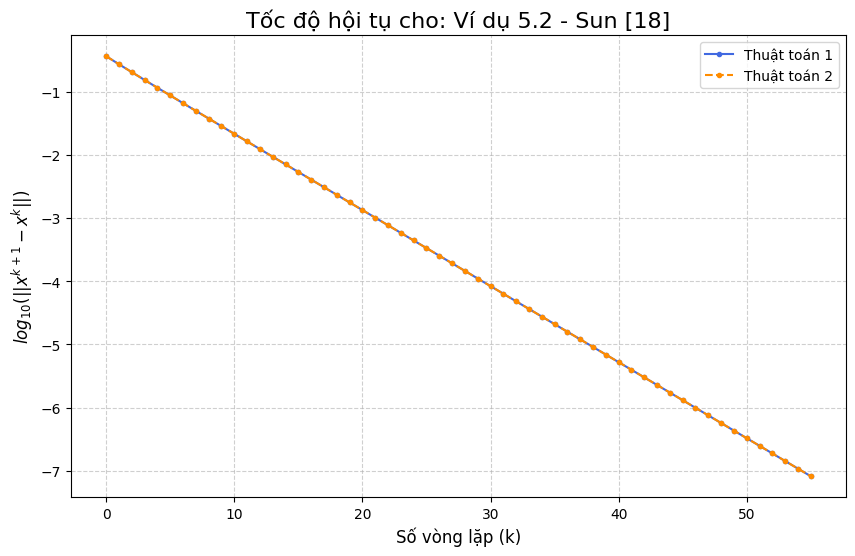

BẮT ĐẦU XỬ LÝ: Ví dụ 5.2 - Sun [18] (n=2)

--- Phân tích bài toán ---
  Hằng số đơn điệu mạnh (α): 3.0000
  Hằng số Lipschitz (L): 5.0000
  Hằng số đồng bức (c): 0.1200

>>> Phân tích cho Thuật toán 1 (Chiếu cơ bản):
  Điều kiện (α > 0): Thỏa mãn. F là đơn điệu mạnh.
  Điều kiện hội tụ: 0 < τ < 2α/L² = 0.2400
  => Chọn τ = 0.2352

>>> Phân tích cho Thuật toán 2 (Chiếu với cỡ bước thay đổi):
  Điều kiện (c > 0): Thỏa mãn. F là 0.1200-đồng bức.
  Điều kiện hội tụ: 0 < τ < 2c = 0.2400
  => Chọn τ = 0.2352

--- Bắt đầu chạy thuật toán ---


BẢNG KẾT QUẢ THỰC NGHIỆM
                   Problem Algorithm  Iterations CPU Time (s) Final Error Step Size (τ) Converged
Ví dụ 5.2 - Sun [18] (n=2)    Alg. 1          14      0.00093    1.76e-07        0.2352        Có
Ví dụ 5.2 - Sun [18] (n=2)    Alg. 2          14      0.00038    1.76e-07        0.2352        Có




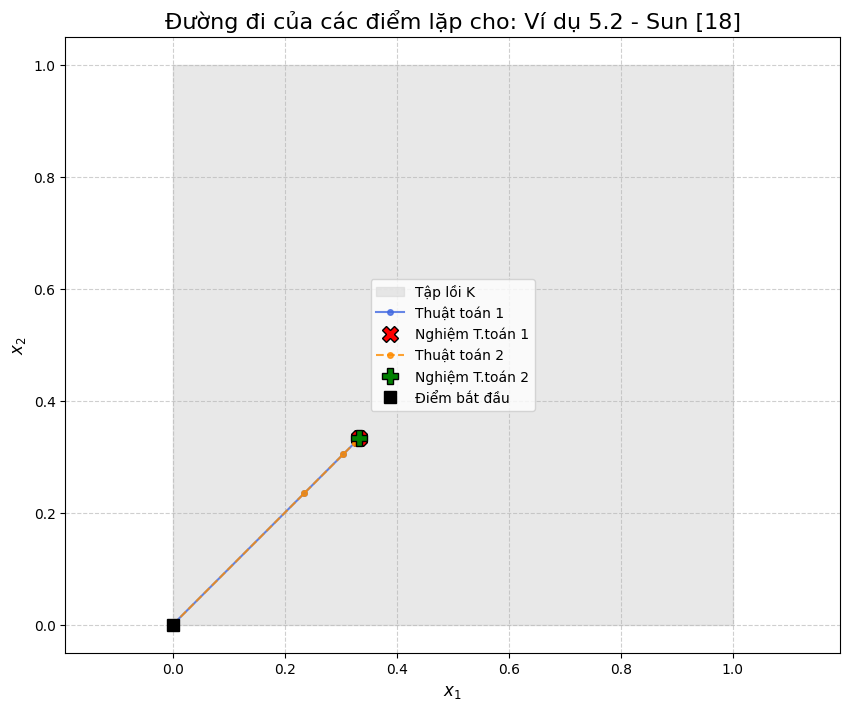

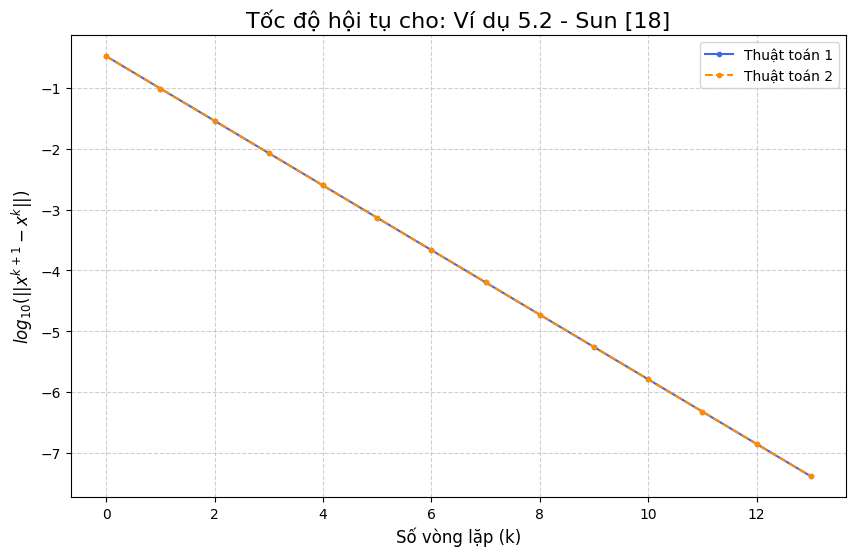

In [ ]:
# Chạy với n=10 để so sánh hiệu năng
sun_problem_10D = create_sun_problem_instance(n=10)
run_and_compare_algorithms(sun_problem_10D)

# Chạy với n=100 để thấy sự khác biệt rõ hơn
# sun_problem_100D = create_sun_problem_instance(n=100)
# run_and_compare_algorithms(sun_problem_100D)

# Chạy với n=2 để vẽ biểu đồ đường đi
sun_problem_2D = create_sun_problem_instance(n=2)
run_and_compare_algorithms(sun_problem_2D)